In [1]:
# Carga de paquetes necesarios para graficar
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd # Para leer archivos
import geopandas as gpd # Para hacer cosas geográficas
import seaborn as sns # Para hacer plots lindos
import networkx as nx # Construcción de la red en NetworkX
import scipy
import template_funciones as tf

# Preambulo

En esta sección cargamos los datos y los visualizamos. También construimos la matriz de adyacencia de la red de museos.

## Carga de datos de los museos

El listado de los museos, con el que se construye el [mapa](https://mapas.museosabiertos.org/museos/caba/), lo podemos encontrar [acá](https://github.com/MuseosAbiertos/Leaflet-museums-OpenStreetMap/blob/principal/data/export.geojson?short_path=bc357f3). También descargamos los barrios de CABA como complemento para los gráficos.

In [2]:
# Leemos el archivo, retenemos aquellos museos que están en CABA, y descartamos aquellos que no tienen latitud y longitud
museos = gpd.read_file('https://raw.githubusercontent.com/MuseosAbiertos/Leaflet-museums-OpenStreetMap/refs/heads/principal/data/export.geojson')
barrios = gpd.read_file('https://cdn.buenosaires.gob.ar/datosabiertos/datasets/ministerio-de-educacion/barrios/barrios.geojson')

## Visualización

<Axes: >

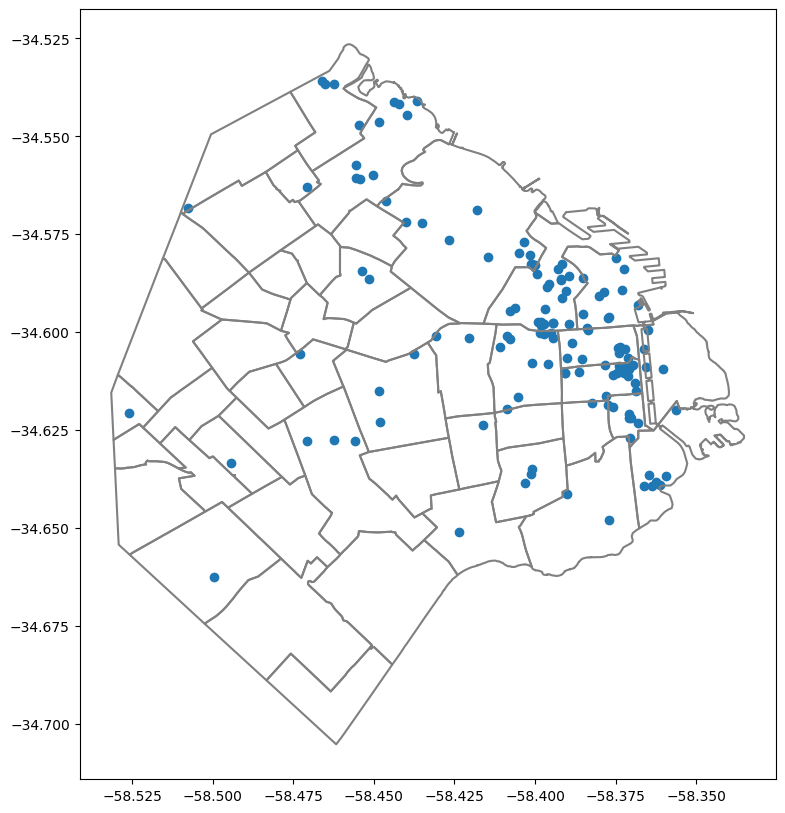

In [3]:
# Armamos el gráfico para visualizar los museos
fig, ax = plt.subplots(figsize=(10, 10))
barrios.boundary.plot(color='gray',ax=ax)
museos.plot(ax=ax)

## Cálculo de la matriz de distancias

Ahora construimos la matriz de distancias entre todos los museos. Como la tierra es un [geoide](https://es.wikipedia.org/wiki/Geoide) (es decir que no es [plana](https://es.wikipedia.org/wiki/Terraplanismo)), el cálculo de distancias no es una operación obvia. Una opción es proyectar a un [sistema de coordenadas local](https://geopandas.org/en/stable/docs/user_guide/projections.html), de forma tal que las distancias euclideas se correspondan con las distancias en metros. En este notebook usamos [EPSG](https://en.wikipedia.org/wiki/EPSG_Geodetic_Parameter_Dataset) 22184.

In [4]:
# En esta línea:
# Tomamos museos, lo convertimos al sistema de coordenadas de interés, extraemos su geometría (los puntos del mapa),
# calculamos sus distancias a los otros puntos de df, redondeamos (obteniendo distancia en metros), y lo convertimos a un array 2D de numpy
D = museos.to_crs("EPSG:22184").geometry.apply(lambda g: museos.to_crs("EPSG:22184").distance(g)).round().to_numpy()

# Resolución del TP

Aquí empieza la aventura... ¡diviertanse y consulten lo que necesiten!

## Punto 1:

Partiendo de la ecuación 3, muestre que el vector de rankings **p** es solución de la ecuación $Mp = b$, con

$$
M = \frac{N}{\alpha}(I - (1 - \alpha)C) \quad \text{y} \quad b = \mathbf{1},
$$

---

**_Respuesta_**

Parto de la ecuación de PageRank $p = (1 - \alpha)Cp + \frac{\alpha}{N} \mathbf{1}$

donde:

- $p \in \mathbb{R}^N$ es el vector de relevancia de cada museo (PageRank)  
- $C \in \mathbb{R}^{N \times N}$ es la matriz de transiciones estocástica por columnas  
- $\alpha \in (0, 1)$ es el factor de amortiguamiento  
- $\mathbf{1} \in \mathbb{R}^N$ es el vector columna lleno de unos  
- $N$ es la cantidad de museos.  

$$
p - (1 - \alpha)Cp = (1 - \alpha)Cp + \frac{\alpha}{N} \mathbf{1} - (1 - \alpha)Cp
$$

$$
p - (1 - \alpha)Cp = \frac{\alpha}{N} \mathbf{1}
$$

$$
(I - (1 - \alpha)C)p = \frac{\alpha}{N} \mathbf{1}
$$

Multiplicando ambos lados por $\frac{N}{\alpha}$:

$$
\frac{N}{\alpha}(I - (1 - \alpha)C)p = \frac{N}{\alpha} \cdot \frac{\alpha}{N} \mathbf{1}
$$

$$
\frac{N}{\alpha}(I - (1 - \alpha)C)p = \mathbf{1}
$$

Por lo tanto, si definimos $M = \frac{N}{\alpha}(I - (1 - \alpha)C)$, se cumple que:

$$
Mp = b \quad \text{con} \quad b = \mathbf{1}
$$



## Punto 2:

¿Qué condiciones se deben cumplir para que exista una única solución a la ecuación del
punto anterior? ¿Se cumplen estas condiciones para la matriz M tal como fue construida
para los museos, cuando 0 < α < 1? Demuestre que se cumplen o dé un contraejemplo

Queremos demostrar que la ecuación $Mp = b$, con

$$
M = \frac{N}{\alpha}(I - (1 - \alpha)C) \quad \text{y} \quad b = \mathbf{1},
$$

tiene una única solución. Para ello, analizamos las condiciones bajo las cuales la matriz $M$ es inversible.


**Tip:** Sea $B \in \mathbb{R}^{n \times n}$ tal que $\|B\|_1 < 1$ se puede demostrar, por el absurdo, que $(I - B)$ es inversible.

Supongamos que $(I - B)$ no es inversible. Entonces, existe un $x \neq 0$ tal que:

$$
(I - B)x = 0  \Rightarrow  Ix-Bx = 0  \Rightarrow  x-Bx = 0  \Rightarrow  x = Bx
$$

Tomamos norma 1 en ambos lados:

$$
\|x\|_1 = \|Bx\|_1 \leq \|B\|_1 \cdot \|x\|_1 < \|x\|_1,
$$

lo cual es una contradicción, ya que la norma de un vector no puede ser estrictamente menor que sí misma. Por lo tanto, $\not\exists x \neq 0$ tal que $(I - B)x = 0$, entonces $(I - B)$ es inversible siempre que $\|B\|_1 < 1$.


**Aplicación al problema**

Queremos demostrar que $M$ es inversible. Notamos que la constante $\frac{N}{\alpha} \in \mathbb{R}$ no afecta la inversibilidad, por lo tanto, basta con demostrar que $(I - (1 - \alpha)C)$ es inversible.

Sabemos que la matriz $C$ es estocástica por columnas, ya que se construye normalizando las columnas de la matriz de adyacencia transpuesta. Esto implica que la suma de cada columna de $C$ es 1, y por lo tanto:

$$
\|C\|_1 = \max_j \sum_i |C_{ij}| = 1.
$$

Entonces:

$$
\|(1 - \alpha)C\|_1 = |1 - \alpha| \cdot \|C\|_1 = 1 - \alpha < 1, \quad \text{ya que } 0 < \alpha < 1.
$$

Aplicando la propiedad anterior, concluimos que $(I - (1 - \alpha)C)$ es inversible, y por lo tanto también lo es $M$.

Finalmente, se concluye que:

$$
Mp = b \quad \text{tiene una única solución} \quad \Leftrightarrow \quad M \text{ es inversible} \quad \Leftrightarrow \quad \|C\|_1 = 1.
$$


(Veamos rapidamente con unas funciones que efectivamente se cumple)

In [5]:
#Creamos la matriz de adyacencia para D y n=3 y creamos tambien su matriz C y su matriz M para alpha=0.5
Aprueba = tf.construye_adyacencia(D,3)
Cprueba = tf.calcula_matriz_C(Aprueba)
Mprueba = tf.calcula_matriz_M(Aprueba, 0.5)

In [6]:
#Usamos la funcion norm de numpy solo para dar un ejemplo 
np.linalg.norm(Cprueba, 1) #vemos que la ||C||1 = 1

np.float64(1.0)

In [7]:
np.linalg.det(Mprueba) #vemos que el det(M)=!0, por ende es inversible. (Tiende a infinito porque la matriz es muy grande 136x136)

C:\Users\mfern\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\linalg\_linalg.py:2383: RuntimeWarning: overflow encountered in det
  r = _umath_linalg.det(a, signature=signature)


np.float64(inf)

In [8]:
np.shape(Mprueba) #miro el tamaño de Mprueba

(136, 136)

## Punto 3:


Lo primero que hacemos es implementar la función que calcula la factorización LU en el template de funciones.

Luego, usando la factorización LU, implementamos la función que nos calcula el Page Rank.

Usando $α = 1/5$, calculamos el Page Rank para los m vecinos más cercanos, com $m = 1, 3, 5, 10$. Para cada valor de m, construimos una visualización del mapa.

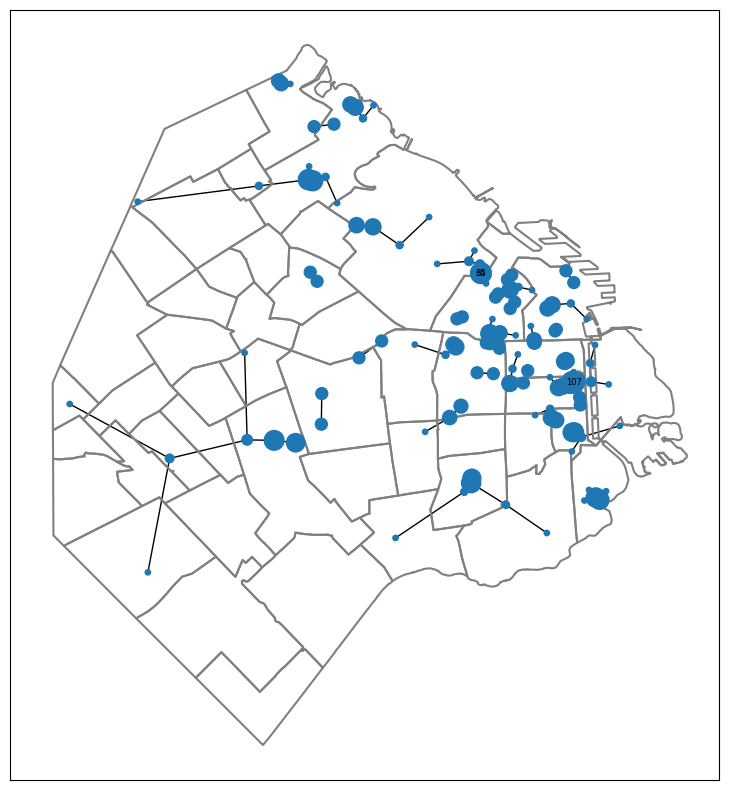

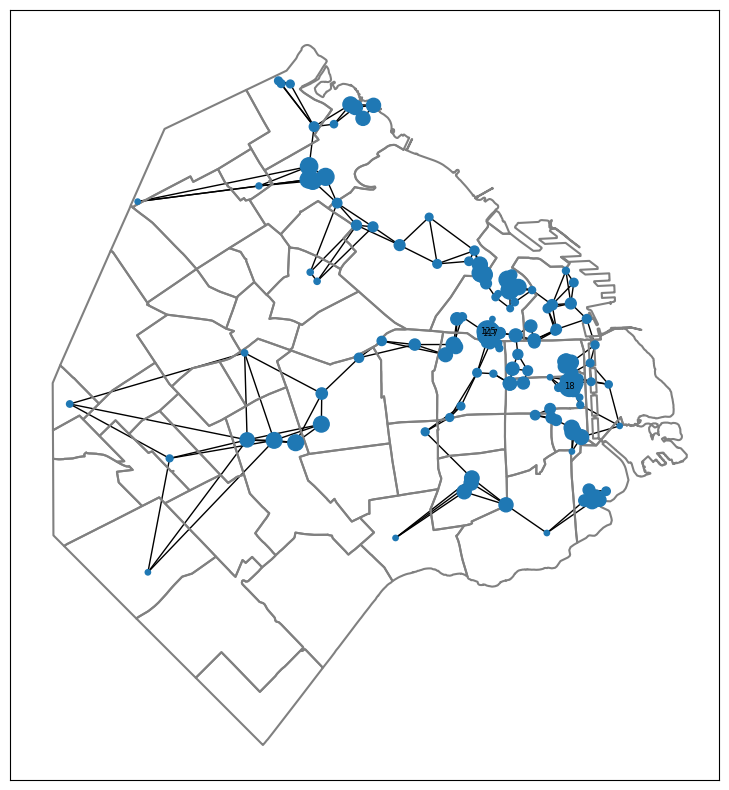

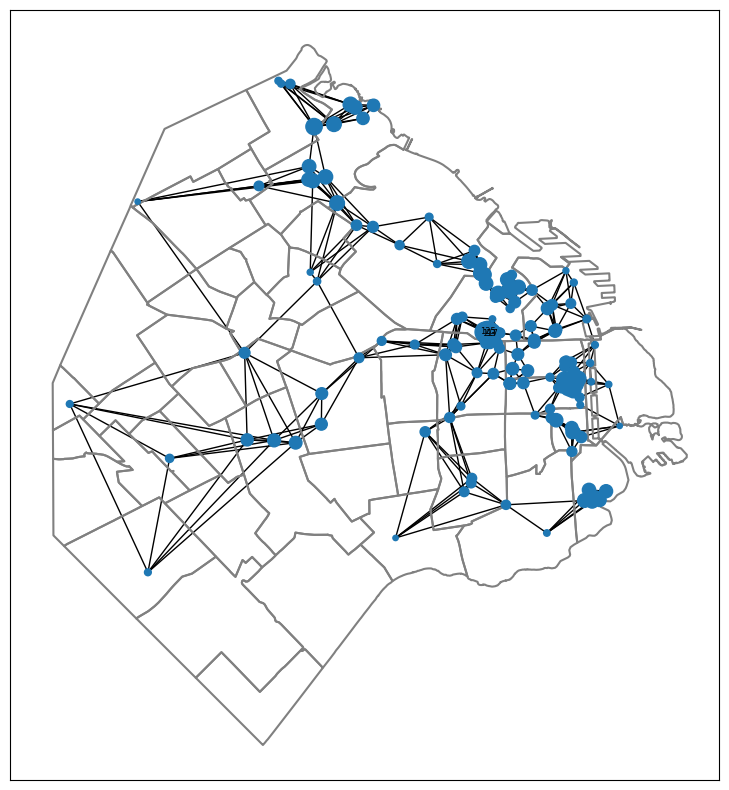

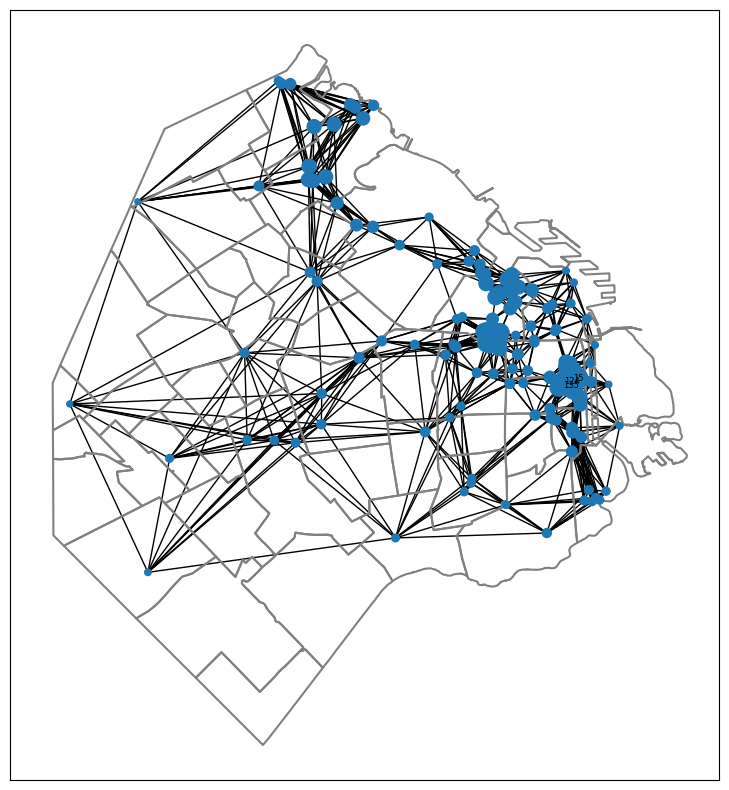

In [9]:
lista_m = [1,3,5,10] # lista de m
pageranks_m = [] # lista para guardar los pageranks de cada m
museos_principales = set() # set para guardar los museos principales (uso set para que no se guarde más de una vez los mismos museos)

for m in lista_m:
    A = tf.construye_adyacencia(D,m)
    G = nx.from_numpy_array(A) # Construimos la red a partir de la matriz de adyacencia
    # Construimos un layout a partir de las coordenadas geográficas
    G_layout = {i:v for i,v in enumerate(zip(museos.to_crs("EPSG:22184").get_coordinates()['x'],museos.to_crs("EPSG:22184").get_coordinates()['y']))}

    factor_escala = 1e4 # Escalamos los nodos 10 mil veces para que sean bien visibles
    fig, ax = plt.subplots(figsize=(10, 10)) # Visualización de la red en el mapa
    barrios.to_crs("EPSG:22184").boundary.plot(color='gray',ax=ax) # Graficamos Los barrios

    pr = tf.calcula_pagerank(A,1/5) # Este va a ser su score Page Rank. Ahora lo reemplazamos con un vector al azar
    pr = pr/pr.sum() # Normalizamos para que sume 1
    pageranks_m.append(pr) # Guardamos el pagerank para cada m

    Nprincipales = 3 # Cantidad de principales
    principales = np.argsort(pr)[-Nprincipales:] # Identificamos a los N principales
    museos_principales.update(principales) # Guardamos todos los que alguna vez fueron principales

    labels = {n: str(n) if i in principales else "" for i, n in enumerate(G.nodes)} # Nombres para esos nodos
    nx.draw_networkx(G,G_layout,node_size = pr*factor_escala, ax=ax,with_labels=False) # Graficamos red
    nx.draw_networkx_labels(G, G_layout, labels=labels, font_size=6, font_color="k") # Agregamos los nombres



En los mapas pudimos ver que al amuentar $m$, los museos más centrales en la ciudad (en Montserrat, San Nicolas y Recoleta, por ejemplo) cobran más relevancia, ya que tienen más museos cerca a los cuales conectarse reciprocamente, mientras que los museos más periféricos (en Flores, por ejemplo) tenian más relevancia cuando la cantidad de vecinos era menor. 

Ahora, usando los datos que guardamos en la lista pagerank_m y en el conjunto museos_principales, graficamos la variación de los valores de Page Rank de los museos principales en función de $m$.

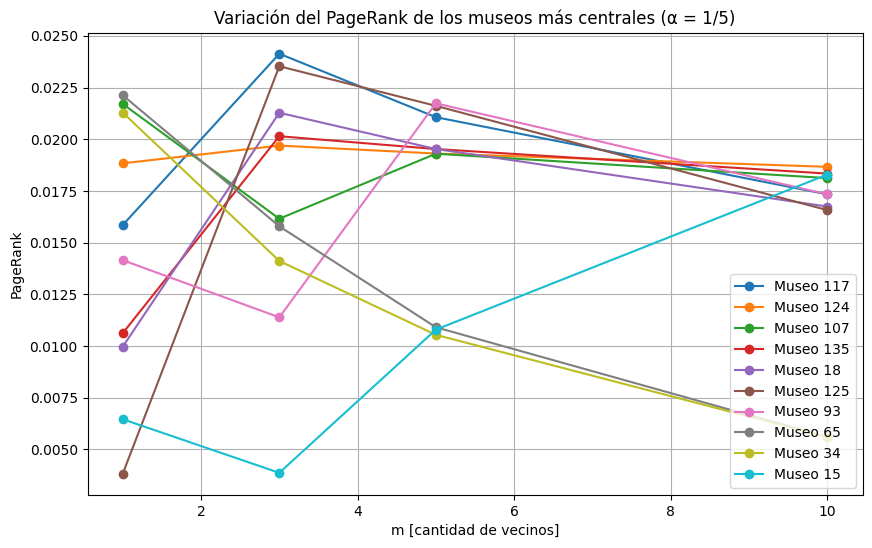

In [10]:
# Convertimos a numpy array para poder graficar
pageranks_m = np.array(pageranks_m) # las filas representan los pageranks para cada valor de m y las columnas representan los museos
museos_principales = np.array(list(museos_principales))

# Para cada museo principal calculamos el promedio de pagerank
promedios_m = [] # lista para guardar los promedios_m de pagerank de cada museo
for museo in museos_principales:
    promedio = pageranks_m[:,museo].mean() # promedio de pagerank para cada museo
    promedios_m.append((museo,promedio))

promedios_ordenados = sorted(promedios_m, key=lambda x: x[1], reverse=True) # ordenamos los promedios_m de mayor a menor

museos_principales = [indice for indice, _ in promedios_ordenados[:]] # tomamos los 3 primeros

plt.figure(figsize=(10, 6))
for i in museos_principales:
    plt.plot(lista_m, pageranks_m[:, i], marker='o', label=f"Museo {i}"
)
plt.xlabel("m [cantidad de vecinos]") 
plt.ylabel("PageRank")
plt.title("Variación del PageRank de los museos más centrales (α = 1/5)")
plt.legend()
plt.grid(True)
plt.show()

Ahora, usando $m = 5$, calculamos el Page Rank para los para los diferentes valores $α = 6/7, 4/5, 2/3, 1/2, 1/3, 1/5, 1/7$. Nuevamente graficamos la visualización del mapa, pero ahora para cada valor de $α$.

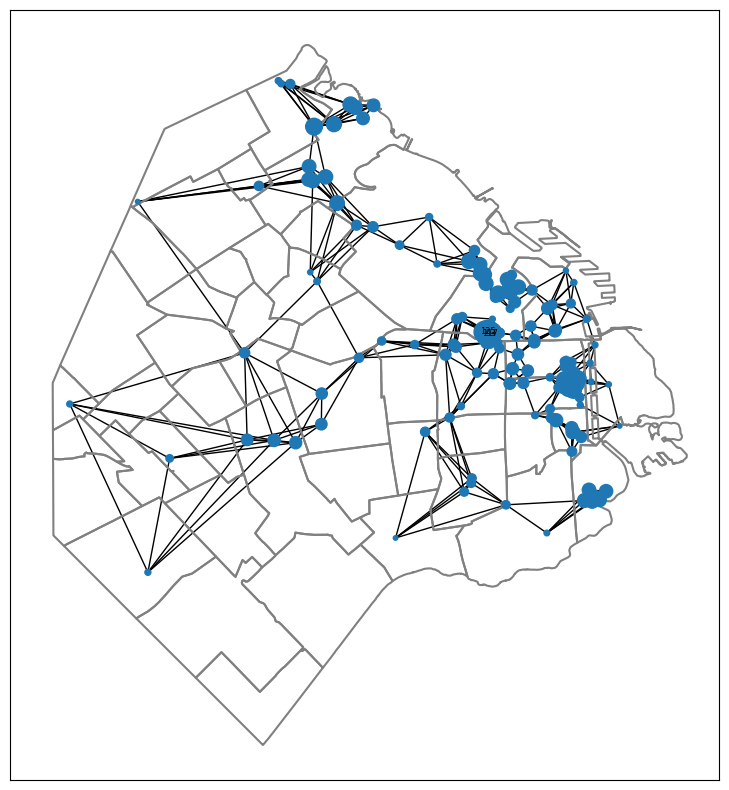

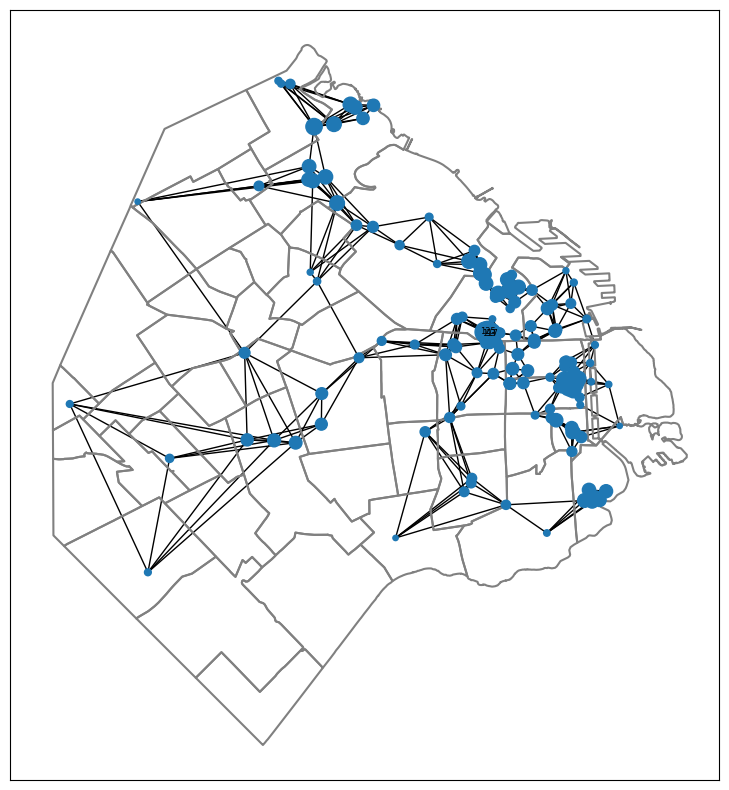

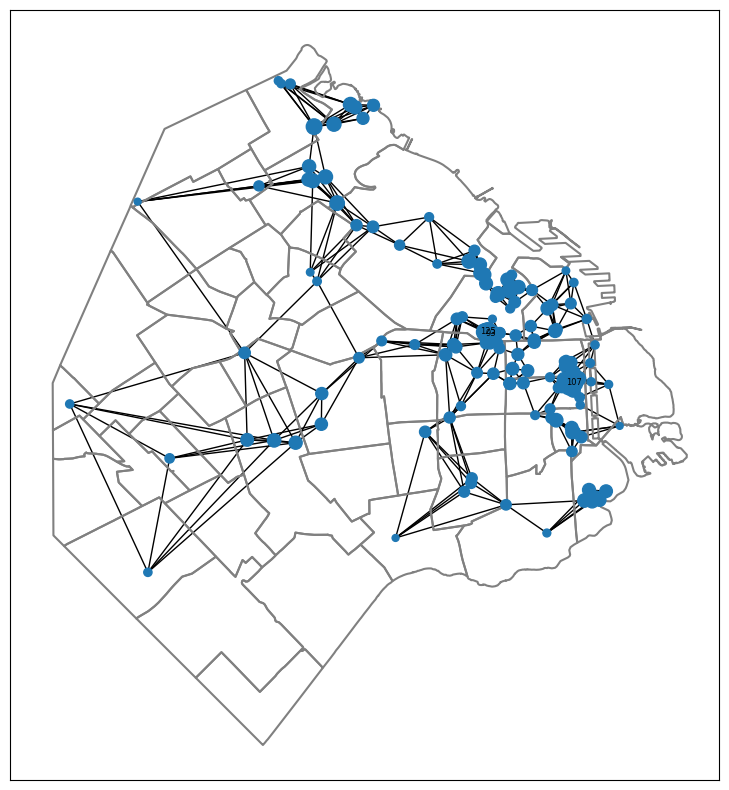

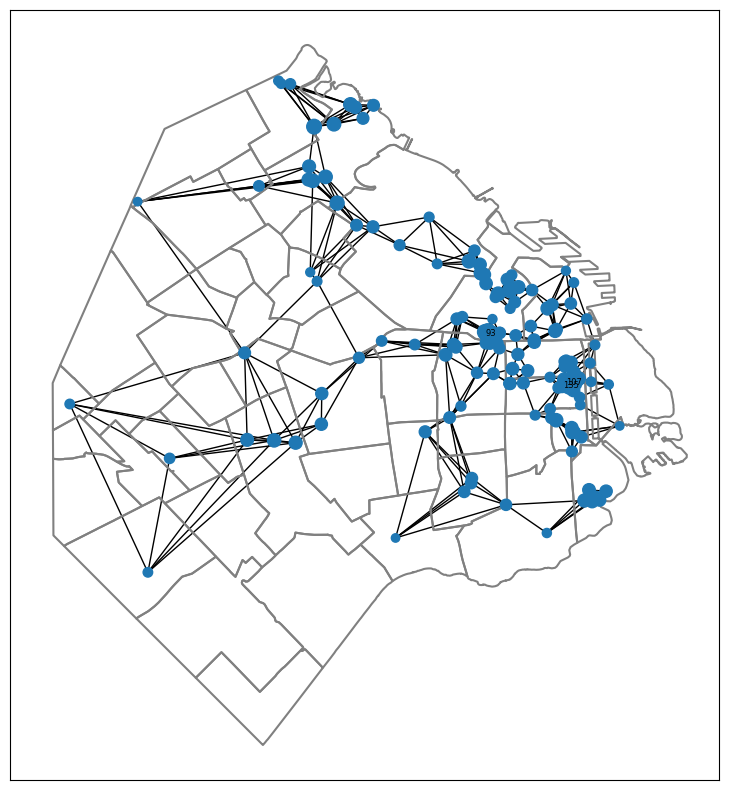

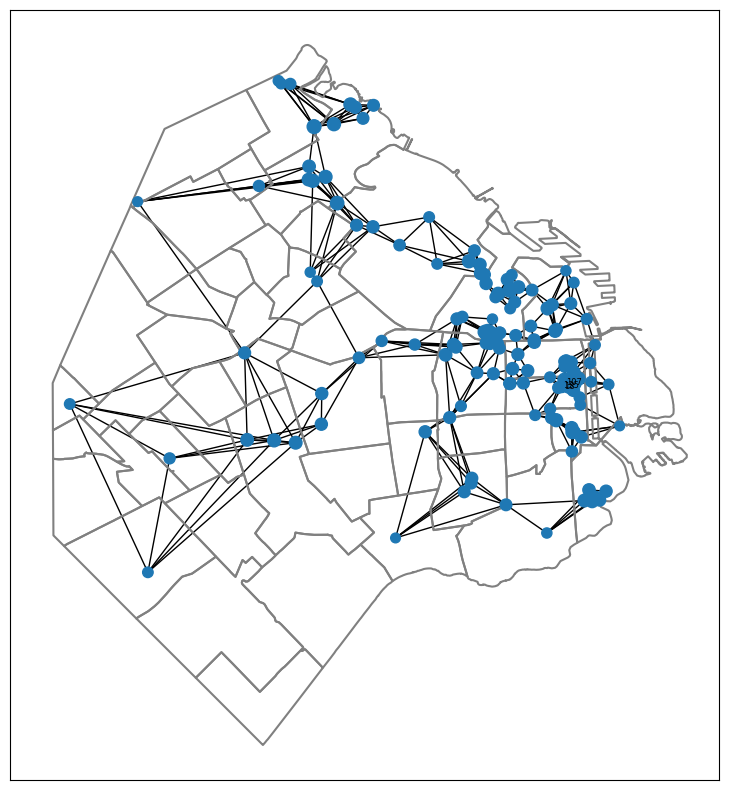

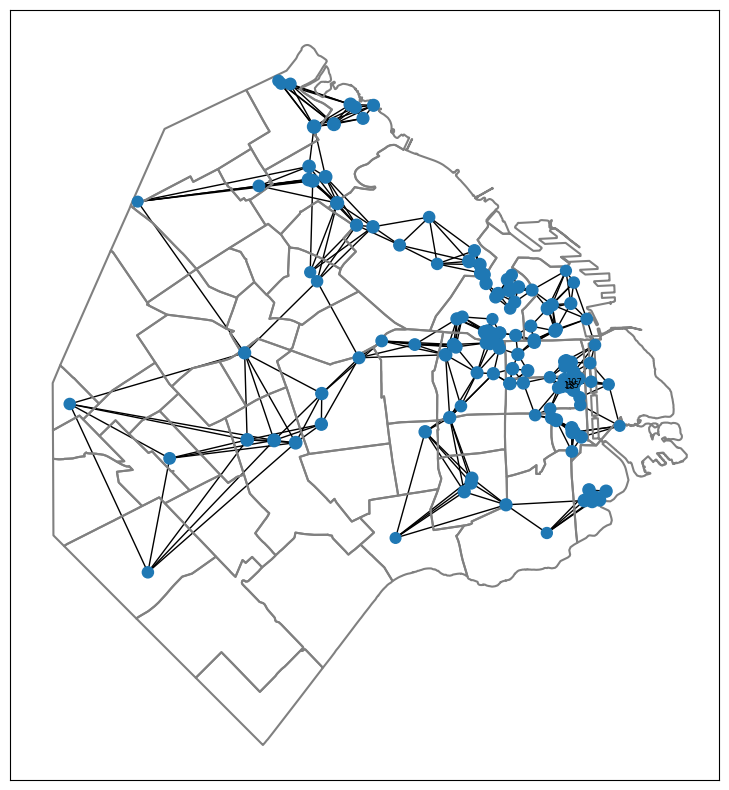

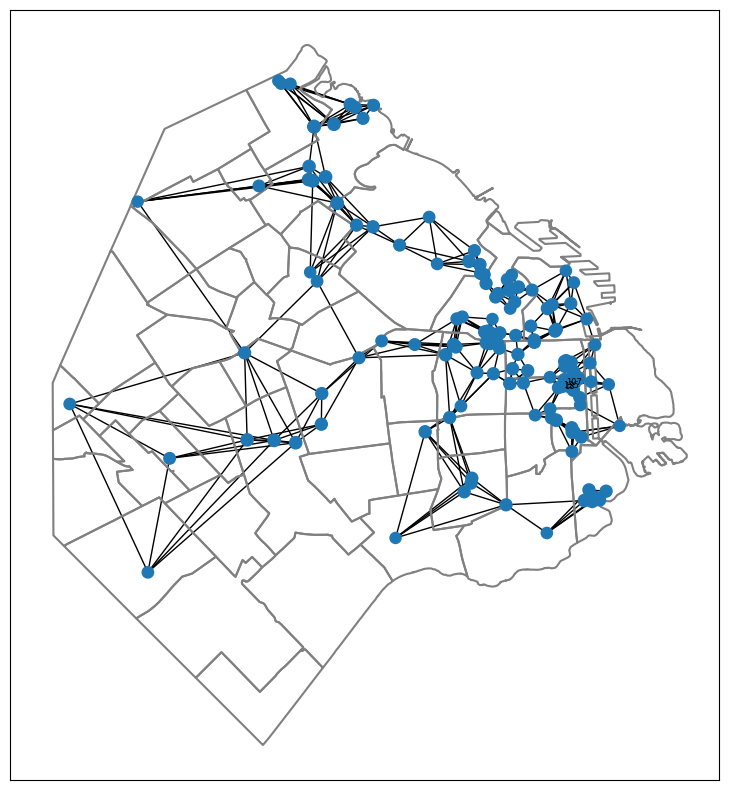

In [11]:
lista_alfa = [1/7, 1/5, 1/3, 1/2, 2/3, 4/5, 6/7]
pageranks_alfa = [] # lista para guardar los pageranks de cada alfa
museos_principales2 = set() # set para guardar los museos principales (uso set para que no se guarde más de una vez los mismos museos)

for alfa in lista_alfa:
    A = tf.construye_adyacencia(D,5)
    G = nx.from_numpy_array(A) # Construimos la red a partir de la matriz de adyacencia
    # Construimos un layout a partir de las coordenadas geográficas
    G_layout = {i:v for i,v in enumerate(zip(museos.to_crs("EPSG:22184").get_coordinates()['x'],museos.to_crs("EPSG:22184").get_coordinates()['y']))}

    factor_escala = 1e4 # Escalamos los nodos 10 mil veces para que sean bien visibles
    fig, ax = plt.subplots(figsize=(10, 10)) # Visualización de la red en el mapa
    barrios.to_crs("EPSG:22184").boundary.plot(color='gray',ax=ax) # Graficamos Los barrios

    pr = tf.calcula_pagerank(A,alfa) # Este va a ser su score Page Rank. Ahora lo reemplazamos con un vector al azar
    pr = pr/pr.sum() # Normalizamos para que sume 1
    pageranks_alfa.append(pr) # Guardamos el pagerank para cada alfa

    Nprincipales = 3 # Cantidad de principales
    principales = np.argsort(pr)[-Nprincipales:] # Identificamos a los N principales
    museos_principales2.update(principales) # Guardamos todos los que alguna vez fueron principales

    labels = {n: str(n) if i in principales else "" for i, n in enumerate(G.nodes)} # Nombres para esos nodos
    nx.draw_networkx(G,G_layout,node_size = pr*factor_escala, ax=ax,with_labels=False) # Graficamos red
    nx.draw_networkx_labels(G, G_layout, labels=labels, font_size=6, font_color="k") # Agregamos los nombres


Mirando los mapas para cada $α$, lo primero que notamos es que no hay tanta variación en la relevancia de los museos como habia cuando variamos $m$. Se nota que los museos más relevantes se mantienen en el centro de CABA (en Montserrat, San Nicolás y Recoleta, por ejemplo), pero a medida que aumenta el valor de $α$ esos museos centrales van perdiendo un poco de su relevancia mientras que los museos más a oeste se hacen más relevantes.

Nuevamente, usando los datos que guardamos en la lista pagerank_alfa y en el conjunto museos_principales2, graficamos la variación de los valores de Page Rank de los museos principales, pero ahora en función de $α$.

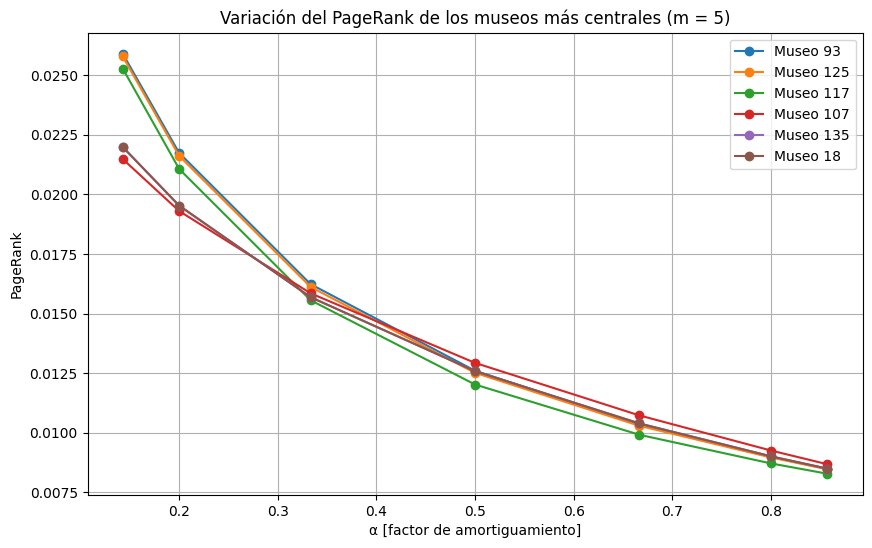

In [12]:
# Convertimos a numpy array para poder graficar
pageranks_alfa = np.array(pageranks_alfa) # las filas representan los pageranks para cada valor de m y las columnas representan los museos
museos_principales2 = np.array(list(museos_principales2))

# Para cada museo principal calculamos el promedio de pagerank
promedios_alfa = [] # lista para guardar los promedios_alfa de pagerank de cada museo
for museo in museos_principales2:
    promedio = pageranks_alfa[:,museo].mean() # promedio de pagerank para cada museo
    promedios_alfa.append((museo,promedio))

promedios_ordenados = sorted(promedios_alfa, key=lambda x: x[1], reverse=True) # ordenamos los promedios_alfa de mayor a menor

museos_principales2 = [indice for indice, _ in promedios_ordenados[:]] # tomamos los 3 primeros

plt.figure(figsize=(10, 6))
for i in museos_principales2:
    plt.plot(lista_alfa, pageranks_alfa[:, i], marker='o', label=f"Museo {i}"
)
plt.xlabel("α [factor de amortiguamiento]")
plt.ylabel("PageRank")
plt.title("Variación del PageRank de los museos más centrales (m = 5)")
plt.legend()
plt.grid(True)
plt.show()


Como nos explica la introducción del trabajo práctico, en el modelo de PageRank la idea es simular una caminata aleatória por una red, en nuestro caso la de museos. En cada paso el caminante tiene dos opciones, moverse al siguiente museo segun la matriz de transición, con probabilidad $1-α$ o "teletransportarse" a un museo al azar, como si empezaras una nueva caminata, con probabilidad $α$. 

Entonces que $α$ tienda a 1 significa que casi siempre el caminante está empezando una caminata nueva en un lugar aleatorio, por ende las caminatas se vuelven muy cortas, y los caminantes tienden a visitar muy pocos museos antes de "teletransportarse" de nuevo. Como están empezando desde un lugar aleatório muchas veces, todos los museos tienen mas o menos la misma oportunidad de ser visitados y por lo tanto el PageRank tiende a uniformarse, como podemos observar en el gráfico. En el limite de $α=1$, el PageRank seria exactamnete uniforme, es decir, todos los museos tendrian el mismo valor de PageRank. 


Lo contrario pasa cuando $α$ tiende a cero. Siginifica que rara vez los caminantes reinician la caminata, por lo tanto las caminatas tienden a ser muy largas. El PageRank se vuelve más dependiente de la estructura de enlaces entre museos, y museos con muchas conexiones entrantes acumulan más PageRank, porque los visitantes tienden a llegar ahi naturalmente.

## Punto 4:
Sabemos que:
* v es el vector que te dice cuántas personas comenzaron su recorrido en cada museo (o sea, su primera visita).
* C es la matriz de transición estocástica. Cada columna representa las probabilidades de que una persona vaya a otros museos desde uno en particular.
Cada columna tiene que sumar 1, porque representa una distribución de probabilidad.
* w es el vector con las visitas totales de cada museo.

Entonces, podemos partir por pasar la matriz B al otro lado

$$v=w*B^{-1}$$
$$B*v=w$$

entonces podemos afirmar que w es igual a v multiplicado por la sumatoria de la matriz c desde 0 hasta r-1:

  $$w= \sum_{k=0}^{r-1}C^{k} * v $$

  $$w= v + C*v + C^{2}*v + ... + C^{r-1}*v$$

Entonces w es igual a v multiplicado por $C^{0}=I$ (que nos da el vector v, es decir, la cantidad de personas que empezaron su recorrido en el museo $v_{i}$) sumado ese v por C (que nos devuelve la cantidad de personas en casa museo luego del primer paso) y así sucesivamente hasta v por $C^{r-1}$ (que nos da el vector con la cantidad de personas en cada museo en el último paso). Por lo tanto, queda probado que multiplicando B por v obtengo w que es el vector con las visitas totales de cada museo $w_{i}$.

Entonces, como B es inversible, si partimos de:
$$B*v=w$$
y multiplicamos por $B^{-1}$ en ambos lados, obtenemos la siguente igualdad:
$$v=w*B^{-1}$$
Por lo tanto, queda demostrado que la multiplición de w por la inversa de B da v.

$ v = B^{-1} * w$ donde $B=\sum_{k=0}^{r-1}C^{k}$




## Punto 5:

Usando las funciones contruídas en el template, calculo la matriz de transición C considerando las distancias entre los museos y, usando el resultado de esa función, calculo la matriz B. Luego, usando ambas matrices y usando la factorización LU resuelvo el sistema $Bv=w$. 

Para finalizar, calculo la cantidad total de visitantes usando una función que calcula la norma 1 de un vector, tambiém implementada en el template. 

In [13]:
C = tf.calcula_matriz_C_continua(D) #Calculo la matriz de transición C considerando las distancias de los museos
B = tf.calcula_B(C, 3) #Calculo B suponiendo que las personas dan r=3 pasos en la red de museos

In [14]:
w = np.loadtxt("visitas.txt") #Carga el vector como un array de numpy
L, U = tf.calculaLU(B) #Calculo la factorizacion LU de B
Y = scipy.linalg.solve_triangular(L, w, lower=True) # Resuelve LY = w
v = scipy.linalg.solve_triangular(U, Y, lower=False) # Resuelve Uv = Y
total_visitantes = round(tf.calcula_norma_1(v))
print('Total de visitantes:', total_visitantes) #Muestro el total de visitantes

Total de visitantes: 136605


## Punto 6:
Supongan que se enteran de que el número total de visitantes por museo $w$ tiene un error del 5 %, y necesitan estimar cómo se propaga ese error a la estimación del número inicial $v$ de visitantes. Llamemos $\tilde{w}$ y $\tilde{v}$ son los valores reales para el total de visitas y el total de primeras visitas respectivamente. Si expresamos este problema usando el número de condición tenemos que
$$
\frac{\lVert v - \tilde{v} \rVert_1}{\lVert v \rVert_1} \leq \operatorname{cond}_1(B) \frac{\lVert w - \tilde{w} \rVert_1}{\lVert w \rVert_1}
$$
Calcule el número de condición de B y estime la cota para el error de estimación de v.

Para estimar el error en el cálculo de v, recordamos que si resolvemos el sistema:

$$
Bv = w
$$

y el vector $w$ contiene errores (por ejemplo, por mediciones inexactas), el error relativo en la solución $v$ puede acotarse usando el **número de condición** de la matriz $B$ en norma 1:

$$
\frac{\lVert v - \tilde{v} \rVert_1}{\lVert v \rVert_1} \leq \operatorname{cond}_1(B) \cdot \frac{\lVert w - \tilde{w} \rVert_1}{\lVert w \rVert_1}
$$

En este trabajo, asumimos que el error relativo en $w$ es del **5%**, es decir:

$$
\frac{\lVert w - \tilde{w} \rVert_1}{\lVert w \rVert_1} = 0.05
$$

Luego, la cota para el error relativo en $v$ es:

$$
\frac{\lVert v - \tilde{v} \rVert_1}{\lVert v \rVert_1} \leq \operatorname{cond}_1(B) \cdot 0.05
$$

Donde $\operatorname{cond}_1(B)$ fue calculada utilizando nuestras propias funciones de norma 1 inducida y calcular inversa, implementada utilizando **factorización LU**.


Calculamos el numero de condicion de $B$ y despues la cota del error de $v$ en funcion del numero de condicion de $B$ y el error de $w$ que es del 5%. Este valor sera la estimacion de cuanto se propaga el error del 5% de $w$ en $v$.

In [15]:
cond_B = tf.calcula_condicion_1_B(B) #calculo el nuemro de condicion de B
error_relativo_w = 0.05 #defino el error relativo de w
cota_error_v = cond_B * error_relativo_w #calculo la cota de error de v
print("Cond1(B)= ", cond_B)
print("La cota de error para v es: ", cota_error_v)

Cond1(B)=  5.051771176665007
La cota de error para v es:  0.2525885588332503


Por ejemplo, en nuestro caso vemos que

$$
\operatorname{cond}_1(B) \approx 5.05  \quad \Rightarrow \quad \frac{\lVert v - \tilde{v} \rVert_1}{\lVert v \rVert_1} \leq 5.05 \cdot 0.05 \approx 0.25
$$

Entonces, el error relativo en $v$ podría llegar hasta un **25%**, lo cual es significativo. Esto muestra que si $B$ está mal condicionada, incluso un pequeño error en los datos de entrada puede producir un gran error en la solución.

Este análisis muestra la importancia del número de condición como indicador de **estabilidad numérica** al resolver sistemas lineales.